In [1]:
import sys
sys.path.append("..")

import os
import json
import pickle
import numpy as np
from scipy.special import softmax
from scipy.integrate import simpson
from scipy.optimize import root

from tabulate import tabulate

import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

2024-01-18 21:12:42.916399: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 21:12:55.733668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from test_model import plot_cm, model_dir, output_dir, data_dir

Importing lots of stuff...


In [3]:
task_name = "scalar1"

In [4]:
print(f"Loading data for task {task_name}...")

with open(f"{data_dir}/processed/cnn/{task_name}_X_test.pkl", "rb") as fin:
    X_test = pickle.load(fin)
with open(f"{data_dir}/processed/cnn/{task_name}_Y_test.pkl", "rb") as fin:
    Y_test = pickle.load(fin)
    
print(f"Loading model...")
cnn = keras.models.load_model(f"{model_dir}/{task_name}_cnn")

y_pred = cnn.predict(X_test, batch_size=100)

Loading data for task scalar1...
Loading model...


2024-01-18 21:13:27.889485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-01-18 21:13:27.890697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-01-18 21:13:27.891698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
2024-01-18 21:13:27.892653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

900/900 [==============================] - 3s 2ms/step


In [18]:
cnn.evaluate(X_test, Y_test)

2813/2813 [==============================] - 6s 2ms/step - loss: 0.0408 - accuracy: 0.9892


[0.04078641161322594, 0.9892444610595703]

In [5]:
y_pred.shape

(90000, 3)

In [6]:
y_pred[:10]

array([[ 2.5255033e+01, -1.7484695e+02,  1.3185028e+02],
       [ 8.5802536e+00,  1.4197329e+01, -2.2009396e+01],
       [ 1.5514240e+00, -2.8859392e+01,  1.9549160e+01],
       [ 5.1595082e+00,  1.2755464e+01, -2.3388783e+01],
       [ 3.9901302e+00, -7.9424018e-01,  2.1400299e+00],
       [ 2.5822689e+01, -7.7578850e+00,  1.9866697e+01],
       [ 7.5220270e+00,  1.5389640e+01, -1.8369047e+01],
       [ 1.7700657e+01, -9.5294027e+00,  1.6204460e+01],
       [ 2.0401395e+02, -8.5032483e+02,  7.2787714e+02],
       [ 1.2069243e+01, -4.1909805e+01,  3.4606731e+01]], dtype=float32)

In [23]:
sig_probs = softmax(y_pred[(Y_test == 2),:], axis=1)[:,2]
bg_probs = softmax(y_pred[(Y_test < 2),:], axis=1)[:,2]

In [24]:
print("Signal last layer:", sig_probs.shape)
print(sig_probs[:5])
print("Background last layer:", bg_probs.shape)
print(bg_probs[:5])

Signal last layer: (30097,)
[1. 1. 1. 1. 1.]
Background last layer: (59903,)
[1.8795017e-16 2.0069458e-16 1.3488673e-01 2.5835815e-03 2.1808343e-15]


In [25]:
def get_eff(probs, thresh):
    """
    Proportion of probabilities identified with label 2.
    """
    thresh = np.array(thresh)
    n_samples = len(probs)
    
    if len(thresh.shape) > 0:
        assert(len(thresh.shape) == 1)
        shape = (len(thresh), len(probs))
        probs = np.broadcast_to(probs, shape)
        thresh = np.broadcast_to(thresh, shape[::-1]).T
        return np.sum(probs >= thresh, axis=1) / n_samples

    return np.sum(probs >= thresh) / n_samples

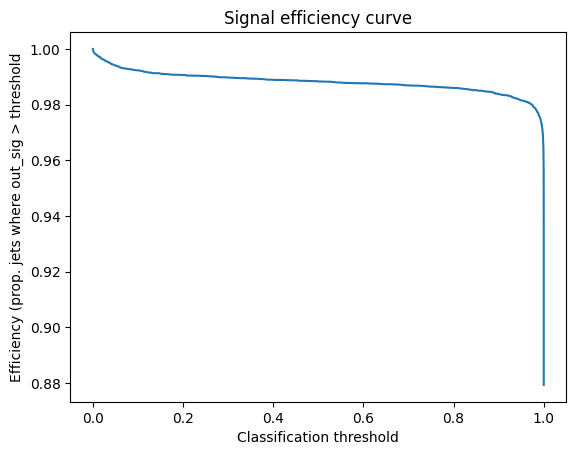

In [33]:
thresh = np.concatenate([
    np.linspace(0, 0.0001, 1000),
    np.linspace(0.0001, 0.99, 1000),
    (1 - np.logspace(np.log10(1 - 0.99), -10, 1000)),
    [1]
])

sig_eff_curve = get_eff(sig_probs, thresh)
plt.title("Signal efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.plot(thresh[:-20], sig_eff_curve[:-20], label="Signal");

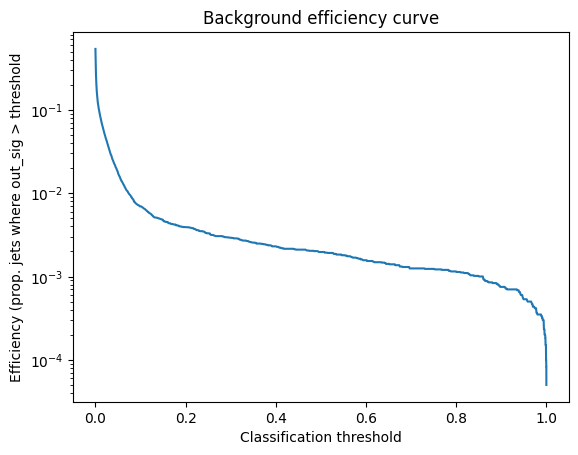

In [34]:
bg_eff_curve = get_eff(bg_probs, thresh)
plt.title("Background efficiency curve")
plt.xlabel("Classification threshold")
plt.ylabel("Efficiency (prop. jets where out_sig > threshold")
plt.plot(thresh[20:-20], bg_eff_curve[20:-20], label="Background");
plt.yscale("log")

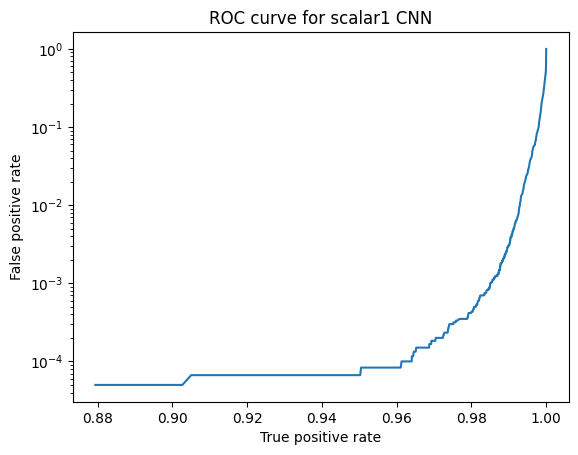

In [35]:
plt.title(f"ROC curve for {task_name} CNN")
plt.plot(sig_eff_curve[:], bg_eff_curve[:])
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.yscale("log")

In [36]:
def get_thresh(probs, desired_eff):
    return root(lambda x: get_eff(probs, x) - desired_eff, 0.5).x[0]

In [30]:
table = []
working_pts = [0.5, 0.9, 0.99, 0.999]
for desired_eff in working_pts:
    thresh = get_thresh(sig_probs, desired_eff)
    sig_eff = get_eff(sig_probs, thresh)
    inv_bg_eff = 1 / get_eff(bg_probs, thresh)
    table.append([thresh, sig_eff, inv_bg_eff])

In [31]:
get_eff(sig_probs, 0.84)

0.985314150912051

In [32]:
# print(tabulate(table, headers=["Thresh", "Sig_eff", "inv bg_eff"]))
print(f"Efficiency analysis table for {task_name} PFN")
print(tabulate(
    table,
    headers=["Classification threshold", r"$\varepsilon_s$", r"$1/\varepsilon_b$"],
    floatfmt=".3f"
))

Efficiency analysis table for scalar1 PFN
  Classification threshold    $\varepsilon_s$    $1/\varepsilon_b$
--------------------------  -----------------  -------------------
                     1.000              0.950            14975.750
                     1.000              0.900            19967.667
                     0.270              0.990              327.339
                     0.002              0.999                4.418
